In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from collections import Counter
import copy
import random
import math

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
LEARNING_RATE = 0.01
NUM_CLIENTS = 5
LOCAL_ROUNDS = 10
GLOBAL_ROUNDS = 10
ALPHA = 0.001
SAMPLE_FRACTIONS = [0.5, 1]
BATCH_SIZE = 64
SEED_NUM = 47

torch.manual_seed(SEED_NUM)
random.seed(SEED_NUM)
np.random.seed(SEED_NUM)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_NUM)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.input_layer = nn.Conv2d(3,16,4,stride = 1)
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(3,32,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(64,256,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self, x):
        x = self.hidden_layer(x)
        return x

In [4]:
def state_dict_to_vector(state_dict):
    return torch.cat([v.flatten().cpu() for v in state_dict.values()])

def fed_avg(global_model, train_loaders, device, sample_fraction=1.0, lr=LEARNING_RATE):
    """
    Performs a single round of Federated Averaging (FedAvg).
    """
    criterion = nn.CrossEntropyLoss()
    num_clients = len(train_loaders)

    # 1. Client Selection
    n_clients = max(1, int(math.ceil(sample_fraction * num_clients)))
    selected_indices = sorted(random.sample(range(num_clients), n_clients))
    selected_loaders = [train_loaders[i] for i in selected_indices]

    global_model.to(device)
    global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    global_vec = state_dict_to_vector(global_state)

    # Calculate total data points of participating clients for weighted averaging
    participating_data = sum(len(loader.dataset) for loader in selected_loaders)

    # Accumulator for the weighted average of model deltas
    global_param_update = [torch.zeros_like(p.data) for p in global_model.parameters()]
    per_client_drifts = []

    # --- Each selected client trains locally ---
    for client_idx, loader in zip(selected_indices, selected_loaders):
        local_model = copy.deepcopy(global_model).to(device)
        optimizer = optim.SGD(local_model.parameters(), lr=lr)
        local_model.train()

        # --- Standard FedAvg Local Training Loop ---
        # (This loop uses the global LOCAL_ROUNDS variable from your script)
        for _ in range(LOCAL_ROUNDS):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = local_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # --- Compute updates and drift ---
        local_state = local_model.state_dict()
        local_vec = state_dict_to_vector(local_state)
        drift_norm = torch.norm(local_vec - global_vec, p=2).item()
        per_client_drifts.append(drift_norm)

        Ni = len(loader.dataset) # Number of data points for this client

        # Δw_i = w_i - w (model delta)
        delta_w_i = [p_local.data - p_global.data
                     for p_local, p_global in zip(local_model.parameters(), global_model.parameters())]

        # Accumulate the weighted model delta
        with torch.no_grad():
            for g_param, delta_w in zip(global_param_update, delta_w_i):
                # Weight by (Ni / N_total_participating)
                g_param += (Ni / participating_data) * delta_w

    # --- Server updates global model ---
    # The global update is the sum of the weighted deltas
    with torch.no_grad():
        for param, delta in zip(global_model.parameters(), global_param_update):
            param.data += delta

    avg_drift = float(np.mean(per_client_drifts))
    return avg_drift


def harmonize_gradients(list_of_flat_updates, eps=1e-9, device_for_work="cpu"):
    """
    Harmonize a list of flattened update vectors (g_i) using pairwise projections.
    Args:
        list_of_flat_updates: list of 1D torch.Tensors (flattened), any device/dtype.
        eps: small constant to avoid division by zero.
        device_for_work: device to move tensors to for harmonization (default: "cpu").

    Returns:
        List of harmonized flattened tensors (same length/order as input).
    Note:
        Performs symmetric pairwise projection once per unordered pair (i < j),
        producing orthogonalized updates for conflicting (negative dot) pairs.
    """
    n = len(list_of_flat_updates)
    if n == 0:
        return []

    # Move to working device and detach/clone to avoid autograd / device mismatch.
    # Use float32 for numeric stability unless input is double.
    working = [g.detach().to(device_for_work).clone() for g in list_of_flat_updates]

    for i in range(n):
        for j in range(i + 1, n):
            g_i = working[i]
            g_j = working[j]

            # ensure 1D
            if g_i.dim() != 1 or g_j.dim() != 1:
                raise ValueError("flattened update tensors must be 1D vectors")

            dot = torch.dot(g_i, g_j).item()

            # conflict if negative dot product (pointing in conflicting directions)
            if dot < 0.0:
                norm_i_sq = torch.dot(g_i, g_i).item()
                norm_j_sq = torch.dot(g_j, g_j).item()

                if norm_i_sq < eps and norm_j_sq < eps:
                    # both near-zero — nothing meaningful to project
                    continue

                # Compute symmetric projections safely.
                # g'_i = g_i - (g_i·g_j / ||g_j||^2) * g_j  (if norm_j_sq > eps)
                # g'_j = g_j - (g_i·g_j / ||g_i||^2) * g_i  (if norm_i_sq > eps)
                # Use the original g_i, g_j for computing both projections.
                
                new_g_i = g_i
                new_g_j = g_j

                if norm_j_sq > eps:
                    coeff_i = dot / norm_j_sq
                    new_g_i = g_i - coeff_i * g_j
                
                if norm_i_sq > eps:
                    coeff_j = dot / norm_i_sq
                    new_g_j = g_j - coeff_j * g_i

                # Write back
                working[i] = new_g_i
                working[j] = new_g_j

    # Return harmonized tensors on the same device/dtype as inputs? We'll return them on device_for_work.
    # Caller can move them as needed before aggregation.
    return working


def fed_gh(global_model, train_loaders, device, sample_fraction=1.0, lr=LEARNING_RATE):
    """
    Performs a single round of Federated Averaging with Gradient Harmonization (FedGH).
    Returns:
        avg_drift: average L2 drift of selected clients (float)
    """

    criterion = nn.CrossEntropyLoss()
    num_clients = len(train_loaders)

    # Client selection
    n_clients = max(1, int(np.ceil(sample_fraction * num_clients)))
    selected_indices = sorted(random.sample(range(num_clients), n_clients))
    selected_loaders = [train_loaders[i] for i in selected_indices]

    global_model.to(device)
    # detach global state to CPU for stable flattening/harmonization
    global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    global_vec = state_dict_to_vector(global_state)  # assume returns 1D torch.Tensor on CPU

    # total participating datapoints
    participating_data = sum(len(loader.dataset) for loader in selected_loaders)

    client_deltas = []
    client_weights = []
    per_client_drifts = []

    # Local training for each selected client
    for client_idx, loader in zip(selected_indices, selected_loaders):
        local_model = copy.deepcopy(global_model).to(device)
        optimizer = optim.SGD(local_model.parameters(), lr=lr)
        local_model.train()

        for _ in range(LOCAL_ROUNDS):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = local_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Flatten local state and compute delta = w_local - w_global
        local_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}
        local_vec = state_dict_to_vector(local_state)

        delta_vector = (local_vec - global_vec).detach()  # on CPU
        drift_norm = torch.norm(delta_vector, p=2).item()
        per_client_drifts.append(drift_norm)

        Ni = len(loader.dataset)
        client_weights.append(Ni / participating_data if participating_data > 0 else 1.0 / n_clients)

        client_deltas.append(delta_vector)  # CPU tensors

    # Harmonize: do all work on CPU (or a designated device)
    harmonized = harmonize_gradients(client_deltas, eps=1e-9, device_for_work="cpu")

    # Weighted aggregation on the CPU flattened vectors
    aggregated_delta_flat = torch.zeros_like(global_vec, device="cpu", dtype=harmonized[0].dtype if len(harmonized)>0 else global_vec.dtype)
    for delta, weight in zip(harmonized, client_weights):
        aggregated_delta_flat += weight * delta

    # Apply the aggregated (flattened) delta back to the global_model parameters (on 'device')
    start_idx = 0
    with torch.no_grad():
        for name, param in global_model.named_parameters():
            numel = param.numel()
            slice_flat = aggregated_delta_flat[start_idx : start_idx + numel]
            param_update = slice_flat.view(param.size()).to(device)
            # Our deltas are (w_local - w_global), so adding yields averaged updated weights
            param.data += param_update
            start_idx += numel

    avg_drift = float(np.mean(per_client_drifts)) if per_client_drifts else 0.0
    return avg_drift

In [5]:
def evaluate(model, test_loader, device):
  model.eval()
  correct, total, test_loss = 0, 0, 0
  criterion = nn.CrossEntropyLoss()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          test_loss += loss.item() * images.size(0)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return test_loss / total, 100 * correct / total

In [6]:
# !pip install fedlab

In [7]:
from fedlab.utils.dataset.partition import CIFAR10Partitioner

heter_loaders = []

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

hetero_dir_part = CIFAR10Partitioner(train_dataset.targets,
                                    NUM_CLIENTS,
                                    balance=None,
                                    partition="dirichlet",
                                    dir_alpha=ALPHA,
                                    seed=SEED_NUM)

heter_loaders = [
    DataLoader(Subset(train_dataset, hetero_dir_part.client_dict[i]), batch_size=BATCH_SIZE, shuffle=True)
    for i in range(NUM_CLIENTS)
]

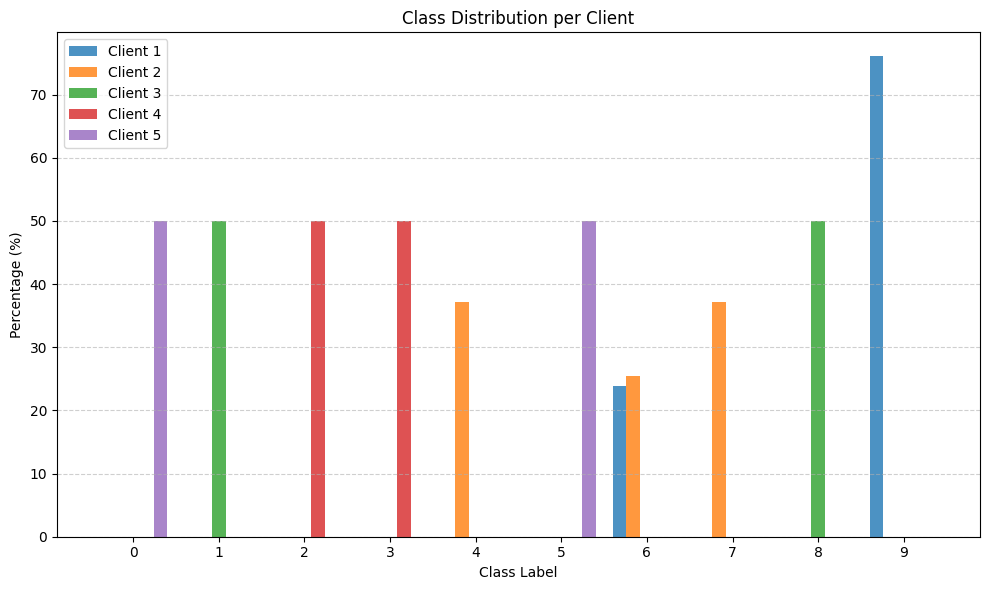

In [8]:

def plot_class_distributions(train_loaders, num_classes=10):
    class_dists = []

    # compute class percentage for each client
    for loader in train_loaders:
        if hasattr(loader.dataset, 'targets'):
            labels = loader.dataset.targets
        elif hasattr(loader.dataset, 'labels'):
            labels = loader.dataset.labels
        else:
            labels = []
            for _, y in loader:
                labels.extend(y.tolist())
            labels = torch.tensor(labels)

        counts = Counter(labels.tolist())
        total = sum(counts.values())
        percents = [counts.get(c, 0) / total * 100 for c in range(num_classes)]
        class_dists.append(percents)

    # plot
    class_labels = np.arange(num_classes)
    width = 0.8 / len(train_loaders)  # to fit all clients side-by-side

    plt.figure(figsize=(10, 6))
    for i, dist in enumerate(class_dists):
        plt.bar(class_labels + i * width, dist, width=width, label=f'Client {i+1}', alpha=0.8)

    plt.xticks(class_labels + width*(len(train_loaders)/2 - 0.5), [str(i) for i in range(num_classes)])
    plt.xlabel("Class Label")
    plt.ylabel("Percentage (%)")
    plt.title("Class Distribution per Client")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_class_distributions(heter_loaders, num_classes=10)

In [9]:
clients = [0,1,2,3,4]
client_train_loaders = heter_loaders

In [10]:
accuracies_fedav = {}
drifts_fedav = {}
accuracies_gradh = {}
drifts_gradh = {}
for sample in SAMPLE_FRACTIONS:
    fedav_global_model = SimpleCNN()
    fedav_global_model.to(device)
    fed_gradh_global_model = SimpleCNN()
    fed_gradh_global_model.to(device)
    accuracies_fedav[sample] = []
    drifts_fedav[sample] = []
    accuracies_gradh[sample] = []
    drifts_gradh[sample] = []
    print(f"\n SAMPLE FRACTION = {sample}")
    for round in range(GLOBAL_ROUNDS):
        print(f"Round {round+1}:")
        fedav_drift = fed_avg(fedav_global_model, client_train_loaders, device, sample_fraction=sample)
        drifts_fedav[sample].append(fedav_drift)
        fedav_loss, fedav_acc = evaluate(fedav_global_model, test_loader, device)
        accuracies_fedav[sample].append(fedav_acc)
        print(f"    FedAVG: Test Loss: {fedav_loss:.4f}, Test Acc: {fedav_acc:.2f}%, Avg Drift: {fedav_drift:.4f}")
        gradh_drift = fed_gh(fed_gradh_global_model, client_train_loaders, device, sample_fraction=sample)
        drifts_gradh[sample].append(gradh_drift)
        gradh_loss, gradh_acc = evaluate(fed_gradh_global_model, test_loader, device)
        accuracies_gradh[sample].append(gradh_acc)
        print(f"    FedGH: Test Loss: {gradh_loss:.4f}, Test Acc: {gradh_acc:.2f}%, Avg Drift: {gradh_drift:.4f}")
    


 SAMPLE FRACTION = 0.5
Round 1:
    FedAVG: Test Loss: 3.1583, Test Acc: 10.25%, Avg Drift: 2.0981
    FedGH: Test Loss: 2.6451, Test Acc: 18.88%, Avg Drift: 1.9566
Round 2:
    FedAVG: Test Loss: 2.4595, Test Acc: 17.25%, Avg Drift: 1.7964
    FedGH: Test Loss: 2.8657, Test Acc: 22.18%, Avg Drift: 1.5231
Round 3:
    FedAVG: Test Loss: 2.8310, Test Acc: 23.31%, Avg Drift: 1.3495
    FedGH: Test Loss: 3.2891, Test Acc: 21.45%, Avg Drift: 1.2921
Round 4:
    FedAVG: Test Loss: 2.6449, Test Acc: 24.85%, Avg Drift: 1.3210
    FedGH: Test Loss: 3.0163, Test Acc: 19.25%, Avg Drift: 1.5820
Round 5:
    FedAVG: Test Loss: 2.9053, Test Acc: 23.44%, Avg Drift: 1.1413
    FedGH: Test Loss: 2.3987, Test Acc: 32.70%, Avg Drift: 1.5795
Round 6:
    FedAVG: Test Loss: 2.5297, Test Acc: 25.98%, Avg Drift: 1.5495
    FedGH: Test Loss: 2.2316, Test Acc: 28.17%, Avg Drift: 1.2118
Round 7:
    FedAVG: Test Loss: 3.1122, Test Acc: 26.72%, Avg Drift: 1.3176
    FedGH: Test Loss: 2.5800, Test Acc: 24.20%, 

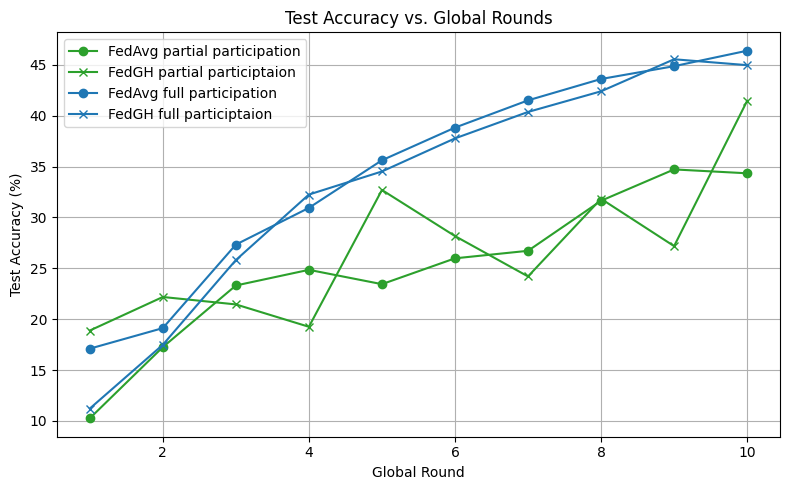

In [12]:
rounds = list(range(1, 11))

# --- Plot 1: Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(rounds, accuracies_fedav[0.5], marker='o', color='tab:green', label='FedAvg partial participation')
plt.plot(rounds, accuracies_gradh[0.5], marker='x', color='tab:green', label='FedGH partial participtaion')
plt.plot(rounds, accuracies_fedav[1], marker='o', color='tab:blue', label='FedAvg full participation')
plt.plot(rounds, accuracies_gradh[1], marker='x', color='tab:blue', label='FedGH full participtaion')
plt.title('Test Accuracy vs. Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

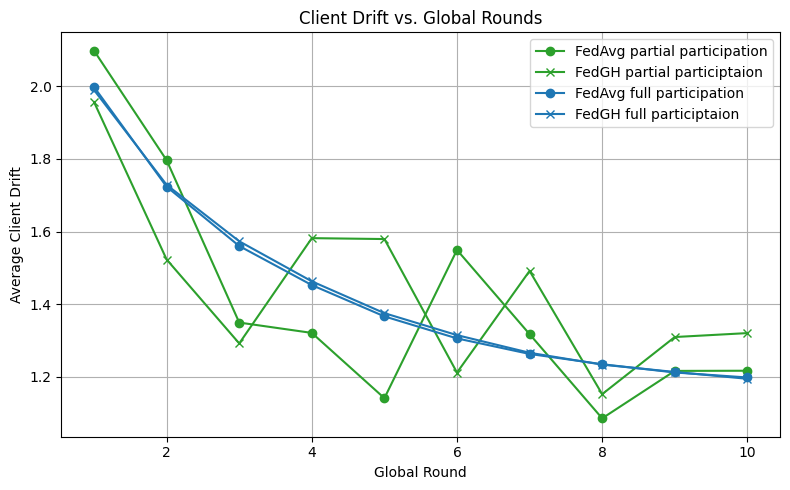

In [13]:
plt.figure(figsize=(8,5))
plt.plot(rounds, drifts_fedav[0.5], marker='o', color='tab:green', label='FedAvg partial participation')
plt.plot(rounds, drifts_gradh[0.5], marker='x', color='tab:green', label='FedGH partial participtaion')
plt.plot(rounds, drifts_fedav[1], marker='o', color='tab:blue', label='FedAvg full participation')
plt.plot(rounds, drifts_gradh[1], marker='x', color='tab:blue', label='FedGH full participtaion')
plt.title('Client Drift vs. Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Average Client Drift')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
import pickle

# Save the dictionary to a pickle file
with open("drifts_gradh.pkl", "wb") as f: # "wb" for write binary
    pickle.dump(drifts_gradh, f)